In [13]:
# test_bias_metrics.ipynb

# %% [markdown]
"""
# Testing Alignment

**Goal**: Demonstrate how to load ensemble data and reference data, perform alignment, 
          and compute standard bias metrics (ME, MAE, RMSE).

We will:
1. Load an ensemble dataset (potentially with multiple members).
2. Load a single-member reference dataset (SPARTACUS).
3. Perform optional spatial and temporal subsetting.
4. Convert to a consistent time scale (e.g., daily sums).
5. Compare:
   - A single member vs reference
   - A partial ensemble mean vs reference (first 5 members)
   - The full ensemble mean vs reference
6. Compute bias metrics using `bias_metrics.py`.
"""

# %%
import sys
import os

sys.path.append(os.path.abspath(".."))

import xarray as xr
import matplotlib.pyplot as plt

# Import custom modules
from data_loading.load_data import load_ensemble_any_latlon, load_dataset
from data_loading.subset_time import get_common_time_range, subset_time
from data_loading.subset_region import subset_dataset  
from utils.temporal_stats import (
    aggregate_to_daily,
)
from utils.bias_metrics import (
    mean_error,
    mean_absolute_error,
    root_mean_squared_error,
    compute_all_bias_metrics
)

# %%
# 1. LOAD DATA
# Adjust file patterns as needed.
ensemble_pattern = os.path.join("..", "data", "total_precipitation_2017010*.nc")
ref_path = os.path.join("..", "data", "INCAL_HOURLY_RR_201701.nc")

# Load ensemble with 2D or 1D lat/lon handling
ds_ensemble = load_ensemble_any_latlon(ensemble_pattern)

# Load single-member reference
ds_ref = xr.open_dataset(ref_path)  # or load_dataset(ref_path)

print("Ensemble dataset:\n", ds_ensemble)
print("Reference dataset:\n", ds_ref)



Ensemble dataset:
 <xarray.Dataset> Size: 2GB
Dimensions:        (member: 11, time: 48, lat: 492, lon: 594)
Coordinates:
  * member         (member) object 88B '00' '01' '02' '03' ... '08' '09' '10'
    lon            (lat, lon) float32 1MB 5.498 5.526 5.554 ... 22.05 22.07 22.1
  * time           (time) datetime64[ns] 384B 2017-01-01 ... 2017-01-02T23:00:00
Dimensions without coordinates: lat
Data variables:
    latitude       (time, lat, lon, member) float32 617MB 42.98 42.98 ... 51.82
    precipitation  (time, lat, lon, member) float64 1GB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    history:  Fri Jan 31 09:51:14 2025: ncrename -v lat,latitude -v lon,longi...
    NCO:      netCDF Operators version 5.1.9 (Homepage = http://nco.sf.net, C...
Reference dataset:
 <xarray.Dataset> Size: 2GB
Dimensions:                  (time: 744, y: 401, x: 701)
Coordinates:
    lambert_conformal_conic  float64 8B ...
    lat                      (y, x) float32 1MB ...
    lon                      (y, x) floa

In [14]:
from data_loading.subset_region import unify_lat_lon_names

ds_ensemble = unify_lat_lon_names(ds_ensemble, lat_name="lat", lon_name="lon")

ds_ref = unify_lat_lon_names(ds_ref, lat_name="lat", lon_name="lon")


print("Ensemble dataset:\n", ds_ensemble)
print("Reference dataset:\n", ds_ref)


Ensemble dataset:
 <xarray.Dataset> Size: 2GB
Dimensions:        (member: 11, time: 48, lat: 492, lon: 594)
Coordinates:
  * member         (member) object 88B '00' '01' '02' '03' ... '08' '09' '10'
    lon            (lat, lon) float32 1MB 5.498 5.526 5.554 ... 22.05 22.07 22.1
  * time           (time) datetime64[ns] 384B 2017-01-01 ... 2017-01-02T23:00:00
Dimensions without coordinates: lat
Data variables:
    lat            (time, lat, lon, member) float32 617MB 42.98 42.98 ... 51.82
    precipitation  (time, lat, lon, member) float64 1GB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    history:  Fri Jan 31 09:51:14 2025: ncrename -v lat,latitude -v lon,longi...
    NCO:      netCDF Operators version 5.1.9 (Homepage = http://nco.sf.net, C...
Reference dataset:
 <xarray.Dataset> Size: 2GB
Dimensions:                  (time: 744, y: 401, x: 701)
Coordinates:
    lambert_conformal_conic  float64 8B ...
    lat                      (y, x) float32 1MB ...
    lon                      (y, x) floa

In [15]:
from data_loading.subset_region import get_reference_extent, subset_dataset

# 2D lat/lon in SPARTACUS => lat_var="lat", lon_var="lon"
ref_bounds = get_reference_extent(ds_ref, lat_var="lat", lon_var="lon")

ds_ens_subset = subset_dataset(ds_ensemble, lat_var="lat", lon_var="lon", bounds=ref_bounds)
ds_ref_subset = subset_dataset(ds_ref,      lat_var="lat", lon_var="lon", bounds=ref_bounds)


print("Ensemble subset:\n", ds_ens_subset)
print("Reference subset:\n", ds_ref_subset)

Ensemble subset:
 <xarray.Dataset> Size: 448MB
Dimensions:        (time: 48, lat: 205, lon: 345, member: 11)
Coordinates:
  * member         (member) object 88B '00' '01' '02' '03' ... '08' '09' '10'
    lon            (lat, lon) float32 283kB 8.102 8.13 8.158 ... 17.71 17.73
  * time           (time) datetime64[ns] 384B 2017-01-01 ... 2017-01-02T23:00:00
Dimensions without coordinates: lat
Data variables:
    lat            (time, lat, lon, member) float32 149MB 45.79 45.79 ... 49.46
    precipitation  (time, lat, lon, member) float64 299MB 0.0 0.0 ... 0.0 0.0
Attributes:
    history:  Fri Jan 31 09:51:14 2025: ncrename -v lat,latitude -v lon,longi...
    NCO:      netCDF Operators version 5.1.9 (Homepage = http://nco.sf.net, C...
Reference subset:
 <xarray.Dataset> Size: 2GB
Dimensions:                  (time: 744, y: 401, x: 701)
Coordinates:
    lambert_conformal_conic  float64 8B nan
    lat                      (y, x) float32 1MB 45.77 45.77 45.77 ... 49.4 49.4
    lon           

In [16]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import xarray as xr
import numpy as np

# Import the subsetting and aggregation tools
from data_loading.subset_time import get_common_time_range, subset_time
from utils.temporal_stats import aggregate_to_daily

# We'll reuse our previously spatially subset datasets
# If you've already done the spatial subset in the same notebook, 
# you can skip reloading them from files. Otherwise:
# ds_ens_subset = xr.open_dataset("../data/ens_subset_spatial.nc")
# ds_ref_subset = xr.open_dataset("../data/ref_subset_spatial.nc")

print("Before time subsetting:")
print("Ensemble subset time:", ds_ens_subset.time.values[[0, -1]])
print("Reference subset time:", ds_ref_subset.time.values[[0, -1]])




Before time subsetting:
Ensemble subset time: ['2017-01-01T00:00:00.000000000' '2017-01-02T23:00:00.000000000']
Reference subset time: ['2017-01-01T00:00:00.000000000' '2017-01-31T23:00:00.000000000']


In [17]:
# 1. GET COMMON TIME RANGE
common_time = get_common_time_range(ds_ens_subset, ds_ref_subset, time_var="time")
print("\nCommon Time Bounds:", common_time)





Common Time Bounds: {'start_time': np.datetime64('2017-01-01T00:00:00.000000000'), 'end_time': np.datetime64('2017-01-02T23:00:00.000000000')}


In [18]:
# 2. SUBSET ENSEMBLE & REFERENCE IN TIME
ds_ens_time = subset_time(ds_ens_subset, time_bounds=common_time, time_var="time")
ds_ref_time = subset_time(ds_ref_subset, time_bounds=common_time, time_var="time")

print("\nAfter time subsetting:")
print("Ensemble time:", ds_ens_time.time.values[[0, -1]])
print("Reference time:", ds_ref_time.time.values[[0, -1]])




After time subsetting:
Ensemble time: ['2017-01-01T00:00:00.000000000' '2017-01-02T23:00:00.000000000']
Reference time: ['2017-01-01T00:00:00.000000000' '2017-01-02T23:00:00.000000000']


In [19]:
# 3. DAILY AGGREGATION (If Ensemble is hourly)
# We can choose 'compute_ens_mean=True' to average over 'member'
ens_daily = aggregate_to_daily(ds_ens_time, "precipitation", method="sum", compute_ens_mean=False)

# Reference (SPARTACUS) is already daily. If it's not in the same variable name, rename or just keep 'RR'
#ref_daily = ds_ref_time["RR"]

ref_daily = aggregate_to_daily(ds_ref_time, "RR", method="sum")

print("\nEnsemble daily precipitation shape:", ens_daily.shape)
print("Reference daily shape:", ref_daily.shape)

# Optional: Inspect data
print("\nSample Ensemble daily precip:", ens_daily.isel(time=0, member=0))
print("Sample Reference daily precip:", ref_daily.isel(time=0))


Ensemble daily precipitation shape: (2, 205, 345, 11)
Reference daily shape: (2, 401, 701)

Sample Ensemble daily precip: <xarray.DataArray 'precipitation' (lat: 205, lon: 345)> Size: 566kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08274078, 0.04153442, 0.02861404, ..., 0.06664276, 0.04283905,
        0.00964737],
       [0.07193756, 0.04093552, 0.03915787, ..., 0.09154129, 0.08959579,
        0.06947327],
       [0.06499863, 0.04240417, 0.05266571, ..., 0.09601212, 0.09983826,
        0.09584427]], shape=(205, 345))
Coordinates:
    member   <U2 8B '00'
    lon      (lat, lon) float32 283kB 8.102 8.13 8.158 ... 17.68 17.71 17.73
    time     datetime64[ns] 8B 2017-01-01
Dimensions without coordinates: lat
Attributes:
    units

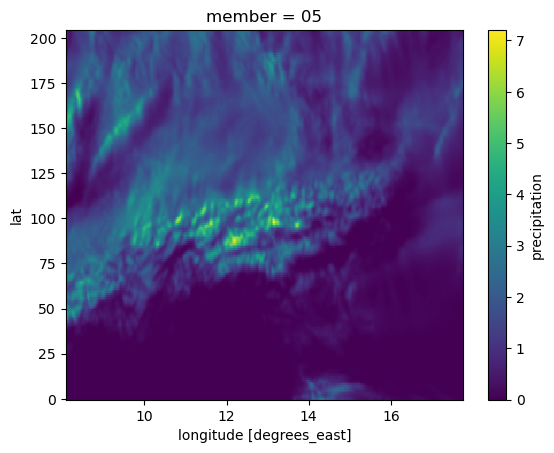

In [20]:
ens_daily.isel(member=5).mean(dim=["time"]).plot()

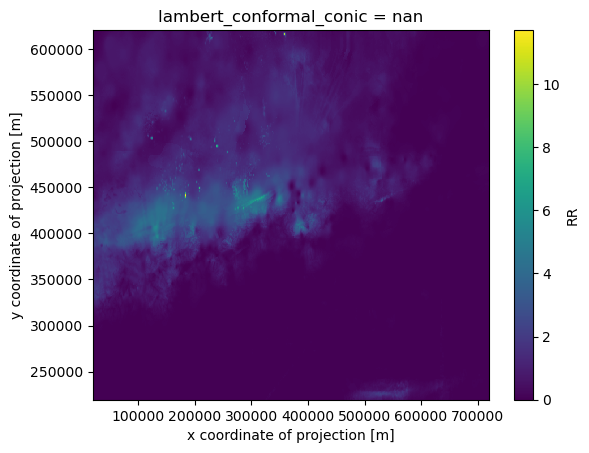

In [21]:
ref_daily.mean(dim=["time"]).plot()